# SPDR S&P 500 ETF Trust

<b> YouTube Tutorial </b> (Published: Jun 22, 2022): https://youtu.be/FSOgnIXDVd4

Spiders (SPDRs)
SPDRs stand for Standard and Poor’s Depositary Receipts. Known as "Spiders," SPDRs are units of an ETF that holds shares of all the companies in the Standard & Poor’s 500 Composite Stock Price Index (S&P 500). SPDRs closely track the price performance and dividend yield of the S&P 500. There are also SPDRs that track the performance of other indexes.

Investors who purchase a SPDR own approximately one tenth of the value of the S&P 500 and receive pro rata quarterly dividends less expenses of the ETF. Unlike an index mutual fund that can only be bought and sold at the end of each trading day, SPDRs trade throughout the trading day.

#### Key Features

<b>Track Record</b> – launched in January 1993, SPY was the very first exchange traded fund listed in the United States.

<b>Diversification</b> – exposure to 500 of the largest US-listed companies across all eleven GICS sectors.

<b>Total Assets Under Management</b> - ~$336B USD (21 Jul 2022)

#### Fund Objective
The SPDR S&P 500 ETF Trust seeks to provide investment results that, before expenses, correspond generally to the price and yield performance of the S&P 500 Index.

#### Fund Information
| Ticker Symbol  | SPY |
| ----------- | ----------- |
| Benchmark      | S&P 500 Index       |
| Inception Date   | 22 Jan 1993        |
| Management Costs (Net Expense Ratio)   | 0.0945% p.a.        |
| Base Currency   | USD        |
| Countries of Registration	   | Australia, Japan, Singapore, United States        |
| Domicile   | United States        |
| Replication Method   | Index Replication        |
| Distribution Frequency   | Quarterly        |

#### References:

[1] Securities and Exchange Commission. Spiders (SPDRs), https://www.sec.gov/answers/spiders.htm

[2] State Street Global Advisors. SPDR S&P 500 ETF Trust, https://www.ssga.com/au/en_gb/institutional/etfs/funds/spdr-sp-500-etf-trust-spy

In [ ]:
!pip install backtrader
!pip install --upgrade pandas_datareader

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 109 kB 8.5 MB/s 
  Attempting uninstall: pandas-datareader
    Found existing installation: pandas-datareader 0.9.0
    Uninstalling pandas-datareader-0.9.0:
      Successfully uninstalled pandas-datareader-0.9.0


In [ ]:
import datetime
import os
import sys
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pandas_datareader import data as pdr
import backtrader as bt

In [ ]:
# import data
def get_data(stocks, start, end):
    stockData = pdr.get_data_yahoo(stocks, start, end)
    return stockData

stockList = ['SPY']
endDate = datetime.datetime.now()
startDate = endDate - datetime.timedelta(weeks=25*52+3)
stockData = get_data(stockList[0], startDate, endDate)
actualStart = stockData.index[0]
data = bt.feeds.PandasData(dataname=stockData)

print('Start Date: {0} \nEnd Date: {1}'.format(startDate, endDate))

Start Date: 1997-07-02 13:28:45.216218 
End Date: 2022-06-22 13:28:45.216218


## Buy and Hold Strategy

In [ ]:
class BuyAndHold(bt.Strategy):
    params = dict(
        results=None
    )

    def start(self):
        self.val_start = self.broker.get_cash()
    def nextstart(self):
        size = math.floor( (self.broker.get_cash() - 10) / self.data[0] )
        self.buy(size=size)
    def stop(self):
        # calculate actual returns
        self.roi = (self.broker.get_value() / self.val_start) - 1

        bah["ROI"].append(self.roi * 100.0)
        bah["Annualised"].append(100*((1+self.roi)**(365/(endDate-actualStart).days) - 1))
        bah["Gross_Return"].append(self.broker.get_value() - self.val_start)

        if self.p.results:
            print('-'*50)
            print('BUY & HOLD')
            print('Starting Value:  ${:,.2f}'.format(self.val_start))
            print('ROI:              {:.2f}%'.format(self.roi * 100.0))
            print('Annualised:       {:.2f}%'.format(100*((1+self.roi)**(365/(endDate-actualStart).days) - 1)))
            print('Gross Return:    ${:,.2f}'.format(self.broker.get_value() - self.val_start))
            print('-'*50)

## Fixed Commission Scheme

In [ ]:
class FixedCommissionScheme(bt.CommInfoBase):
    paras = (
        ('commission', 10),
        ('stocklike', True),
        ('commtype', bt.CommInfoBase.COMM_FIXED)
    )
    def _getcommission(self, size, price, pseudoexec):
        return self.p.commission

## Cash Market Analysis

In [ ]:
class CashMarket(bt.analyzers.Analyzer):
    """
    Analyzer returning cash and market values
    """

    def create_analysis(self):
        self.rets = {}
        self.vals = 0.0

    def notify_cashvalue(self, cash, value):
        self.vals = (
            self.strategy.datetime.datetime().strftime("%Y-%m-%d"),
            cash,
            value,
        )
        self.rets[len(self)] = self.vals

    def get_analysis(self):
        return self.rets

## Buy and Hold More - DCA'ing

In [ ]:
global dca
dca = {key:[] for key in ["Trades","Value","Cost","Gross_Return","Gross_Per","Fund_Value", "Annualised"]}

global bah
bah = {key:[] for key in ["ROI","Annualised","Gross_Return"]}

In [ ]:
class BuyAndHold_More_Fund(bt.Strategy):
    params = dict(
        monthly_cash=1000,
        monthly_range=[1],
        logging=False,
        results=None
    )
    def __init__(self):
        self.order = None
        self.totalcost = 0
        self.cost_wo_bro = 0
        self.units = 0
        self.times = 0
    def log(self, txt, dt=None):
        dt = dt or self.datas[0].datetime.date(0)
        print('%s, %s' % (dt.isoformat(), txt))
    def start(self):
        self.broker.set_fundmode(fundmode=True, fundstartval=100.0)
        self.cash_start = self.broker.get_cash()
        self.val_start = 100.0
        # ADD A TIMER
        self.add_timer(
            when=bt.timer.SESSION_START,
            monthdays=[i for i in self.p.monthly_range],
            monthcarry=True
            # timername='buytimer',
        )

    def notify_timer(self, timer, when, *args):
        self.broker.add_cash(self.p.monthly_cash)
        target_value = self.broker.get_value() + self.p.monthly_cash - 10
        self.order_target_value(target=target_value)

    def notify_order(self, order):
        if order.status in [order.Submitted, order.Accepted]:
            return

        if order.status in [order.Completed]:
            if order.isbuy():
                if self.p.logging:
                    self.log(
                        'BUY EXECUTED, Price %.2f, Cost %.2f, Comm %.2f, Size %.0f' %
                        (order.executed.price,
                        order.executed.value,
                        order.executed.comm,
                        order.executed.size)
                    )
                self.units += order.executed.size
                self.totalcost += order.executed.value + order.executed.comm
                self.cost_wo_bro += order.executed.value
                self.times += 1
        elif order.status in [order.Canceled, order.Margin, order.Rejected]:
            if self.p.logging:
                self.log('Order Canceled/Margin/Rejected')
                print(order.status, [order.Canceled, order.Margin, order.Rejected])
        self.order = None

    def stop(self):
        # calculate actual returns
        self.roi = (self.broker.get_value() / self.cash_start) - 1
        self.froi = (self.broker.get_fundvalue() - self.val_start)
        value = self.datas[0].close * self.units + self.broker.get_cash()
        dca["Trades"].append(self.times)
        dca["Value"].append(value)
        dca["Cost"].append(self.totalcost)
        dca["Gross_Return"].append(value - self.totalcost)
        dca["Gross_Per"].append((value/self.totalcost - 1) * 100)
        dca["Fund_Value"].append(self.froi)
        dca["Annualised"].append(100*((1+self.froi/100)**(365/(endDate - actualStart).days) - 1))
        if self.p.results:
            print('-'*50)
            print('BUY & BUY MORE')
            print('Time in Market: {:.1f} years'.format((endDate - actualStart).days/365))
            print('#Times:         {:.0f}'.format(self.times))
            print('Value:         ${:,.2f}'.format(value))
            print('Cost:          ${:,.2f}'.format(self.totalcost))
            print('Gross Return:  ${:,.2f}'.format(value - self.totalcost))
            print('Gross %:        {:.2f}%'.format((value/self.totalcost - 1) * 100))
            print('ROI:            {:.2f}%'.format(100.0 * self.roi))
            print('Fund Value:     {:.2f}%'.format(self.froi))
            print('Annualised:     {:.2f}%'.format(100*((1+self.froi/100)**(365/(endDate - actualStart).days) - 1)))
            print('-'*50)

In [ ]:
def run(data, results=True, plot=False):
    # BUY and HOLD
    cerebro = bt.Cerebro()
    cerebro.adddata(data)
    cerebro.addstrategy(BuyAndHold, results=results)

    # Broker Information
    broker_args = dict(coc=True)
    cerebro.broker = bt.brokers.BackBroker(**broker_args)
    comminfo = FixedCommissionScheme()
    cerebro.broker.addcommissioninfo(comminfo)
    cerebro.broker.set_cash(300000)

#     # BUY and BUY MORE
    cerebro1 = bt.Cerebro()
    cerebro1.adddata(data)
    cerebro1.addstrategy(BuyAndHold_More_Fund,
                         monthly_cash=1000,
                         monthly_range=[1],
                         logging=False,
                         results=results)

#     # Broker Information
    broker_args = dict(coc=True)
    cerebro1.broker = bt.brokers.BackBroker(**broker_args)
    comminfo = FixedCommissionScheme()
    cerebro1.broker.addcommissioninfo(comminfo)
    cerebro1.broker.set_cash(10)

    # Add Analyzers
    cerebro.addanalyzer(CashMarket, _name="cash_market")
    cerebro1.addanalyzer(CashMarket, _name="cash_market")

    results_dca = cerebro1.run()
    results_bah = cerebro.run()

    if plot:
        %matplotlib ipympl
        # cerebro.plot(iplot=False, style='candlestick')
        cerebro1.plot(iplot=False, style='candlestick')

    return results_dca, results_bah

--------------------------------------------------
BUY & BUY MORE
Time in Market: 25.0 years
#Times:         300
Value:         $772,090.98
Cost:          $299,813.10
Gross Return:  $472,277.88
Gross %:        157.52%
ROI:            7720809.79%
Fund Value:     312.66%
Annualised:     5.84%
--------------------------------------------------
--------------------------------------------------
BUY & HOLD
Starting Value:  $300,000.00
ROI:              312.97%
Annualised:       5.84%
Gross Return:    $938,902.55
--------------------------------------------------


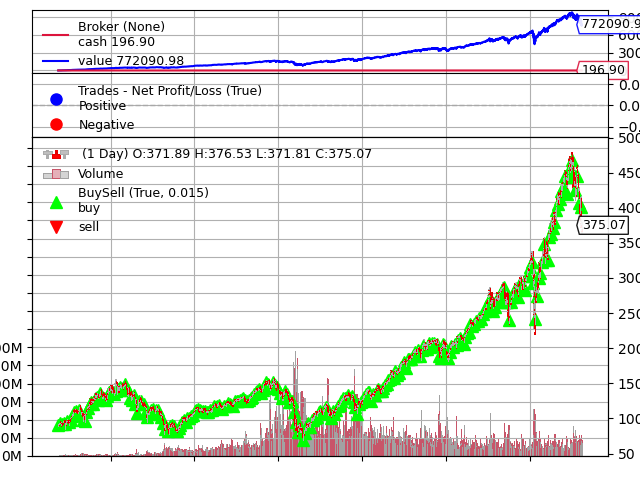

In [ ]:
results_dca, results_bah = run(data, results=True, plot=True)

## DCA results

In [ ]:
# results_dca, results_bah

dictionary1 = results_dca[0].analyzers.getbyname("cash_market").get_analysis()
df1 = pd.DataFrame(dictionary1).T
df1.columns = ["Date", "Cash", "Value"]
df1["Date"] = pd.to_datetime(df1["Date"])
df1["TotalValue"] = df1["Cash"] + df1["Value"]
df1["CashFlow"] = np.where(df1["Cash"] > 1000, 1000, 0)
df1["TotalCash"] =  df1["CashFlow"].cumsum(axis=0)
df1 = df1.set_index("Date")
df1 = df1.drop(["Cash", "Value", "CashFlow"], axis=1)
date_list = df1.index.tolist()

mth_rets_dca = pd.DataFrame(data=date_list, index=date_list).resample('MS')[0].agg([min, max])
mth_rets_dca.rename_axis('Date',inplace=True)

mth_join = mth_rets_dca.merge(df1,how='inner',left_on=['min'],right_on=['Date'])
mth_join.index = mth_rets_dca.index
mth_join2 = mth_join.merge(df1,how='inner',left_on=['max'],right_on=['Date'])
mth_join2.index = mth_rets_dca.index

mth_rets_dca["Per_Ret"] = (mth_join2["TotalValue_y"] - mth_join2["TotalValue_x"])/mth_join2["TotalValue_x"]
mth_rets_dca["Gross_Ret"] = (mth_join2["TotalValue_y"] - mth_join2["TotalCash_y"])
mth_rets_dca["Per_Gross_Ret"] = (mth_join2["TotalValue_y"] - mth_join2["TotalCash_y"])/mth_join2["TotalCash_y"]

mth_rets_dca

,min,max,Per_Ret,Gross_Ret,Per_Gross_Ret
Date,,,,,
1997-07-01,1997-07-02,1997-07-31,0.049571,70.5625,0.070563
1997-08-01,1997-08-01,1997-08-29,-0.021867,21.25,0.010625
1997-09-01,1997-09-02,1997-09-30,0.002453,90.5,0.030167
1997-10-01,1997-10-01,1997-10-31,-0.025632,24.625,0.006156
1997-11-01,1997-11-03,1997-11-28,0.010209,158.125,0.031625
...,...,...,...,...,...
2022-02-01,2022-02-01,2022-02-28,-0.036401,598705.527023,2.022654
2022-03-01,2022-03-01,2022-03-31,0.050522,629644.397018,2.120015
2022-04-01,2022-04-01,2022-04-29,-0.090205,548355.046921,1.840118


## Lump Sum / Buy and Hold results

In [ ]:
# results_dca, results_bah

lump_sum = 300000

dictionary = results_bah[0].analyzers.getbyname("cash_market").get_analysis()
df = pd.DataFrame(dictionary).T
df.columns = ["Date", "Cash", "Value"]
df["Date"] = pd.to_datetime(df["Date"])
df["TotalValue"] = df["Cash"] + df["Value"]
df["CashFlow"] = np.where(df["Cash"] > 1000, 1000, 0)
df["TotalCash"] =  df["CashFlow"].cumsum(axis=0)
df = df.set_index("Date")
df = df.drop(["Cash", "Value", "CashFlow"], axis=1)
date_list = df.index.tolist()

mth_rets_bah = pd.DataFrame(data=date_list, index=date_list).resample('MS')[0].agg([min, max])
mth_rets_bah.rename_axis('Date',inplace=True)

mth_join = mth_rets_bah.merge(df,how='inner',left_on=['min'],right_on=['Date'])
mth_join.index = mth_rets_bah.index
mth_join2 = mth_join.merge(df,how='inner',left_on=['max'],right_on=['Date'])
mth_join2.index = mth_rets_bah.index

mth_rets_bah["Per_Ret"] = (mth_join2["TotalValue_y"] - lump_sum)/lump_sum
mth_rets_bah["Gross_Ret"] = (mth_join2["TotalValue_y"] - lump_sum)
mth_rets_bah["Per_Gross_Ret"] = (mth_join2["TotalValue_y"] - lump_sum)/lump_sum

mth_rets_bah

,min,max,Per_Ret,Gross_Ret,Per_Gross_Ret
Date,,,,,
1997-07-01,1997-07-02,1997-07-31,0.049699,14909.8125,0.049699
1997-08-01,1997-08-01,1997-08-29,-0.004662,-1398.75,-0.004662
1997-09-01,1997-09-02,1997-09-30,0.039378,11813.25,0.039378
1997-10-01,1997-10-01,1997-10-31,0.013917,4175.0625,0.013917
1997-11-01,1997-11-03,1997-11-28,0.05314,15942.0,0.05314
...,...,...,...,...,...
2022-02-01,2022-02-01,2022-02-28,3.807605,1142281.531128,3.807605
2022-03-01,2022-03-01,2022-03-31,3.972865,1191859.593384,3.972865
2022-04-01,2022-04-01,2022-04-29,3.536429,1060928.625,3.536429


## Compare Gross Rate of Return (%) / ROI(%)

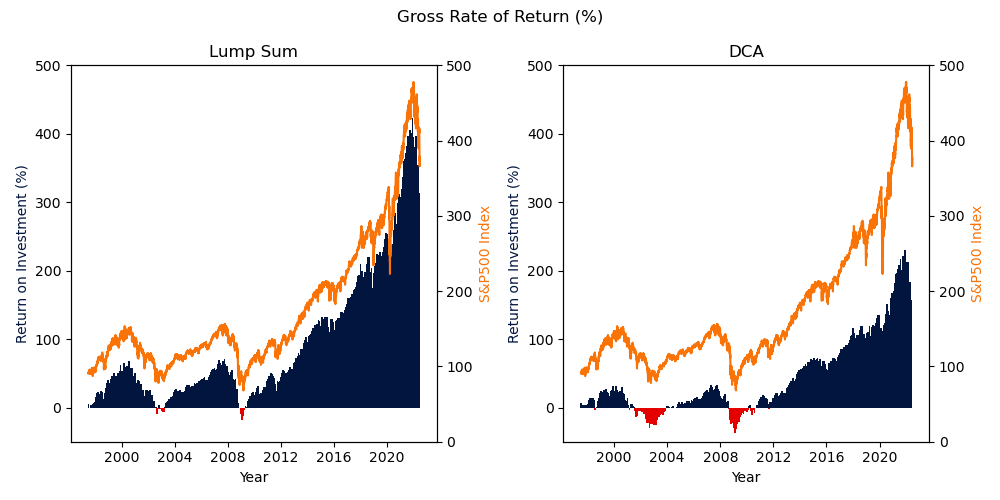

In [ ]:
fig = plt.figure(figsize=(10,5))

ax1 = fig.add_subplot(121)   #top left
ax3 = fig.add_subplot(122)   #top right

ax1.bar(mth_rets_bah.index, mth_rets_bah.Per_Gross_Ret*100, color=np.where(mth_rets_bah.Per_Gross_Ret < 0, 'xkcd:red', 'xkcd:navy'), width=50)
ax3.bar(mth_rets_dca.index, mth_rets_dca.Per_Gross_Ret*100, color=np.where(mth_rets_dca.Per_Gross_Ret < 0, 'xkcd:red', 'xkcd:navy'), width=50)
ax2 = ax3.twinx()
ax4 = ax1.twinx()
ax4.plot(stockData.index, stockData.Close, color='xkcd:orange')
ax2.plot(stockData.index, stockData.Close, color='xkcd:orange')

ax2.set_ylim(0, 500)
ax4.set_ylim(0, 500)
ax1.set_ylim(-50, 500)
ax3.set_ylim(-50, 500)

ax3.set_title("DCA")
ax1.set_title("Lump Sum")
ax1.set_xlabel("Year")
ax3.set_xlabel("Year")
ax1.set_ylabel("Return on Investment (%)", color='xkcd:navy')
ax3.set_ylabel("Return on Investment (%)", color='xkcd:navy')
ax2.set_ylabel('S&P500 Index', color='xkcd:orange')
ax4.set_ylabel('S&P500 Index', color='xkcd:orange')

plt.suptitle('Gross Rate of Return (%)')
fig.tight_layout()
plt.show()

## Compare Gross Return ($m)

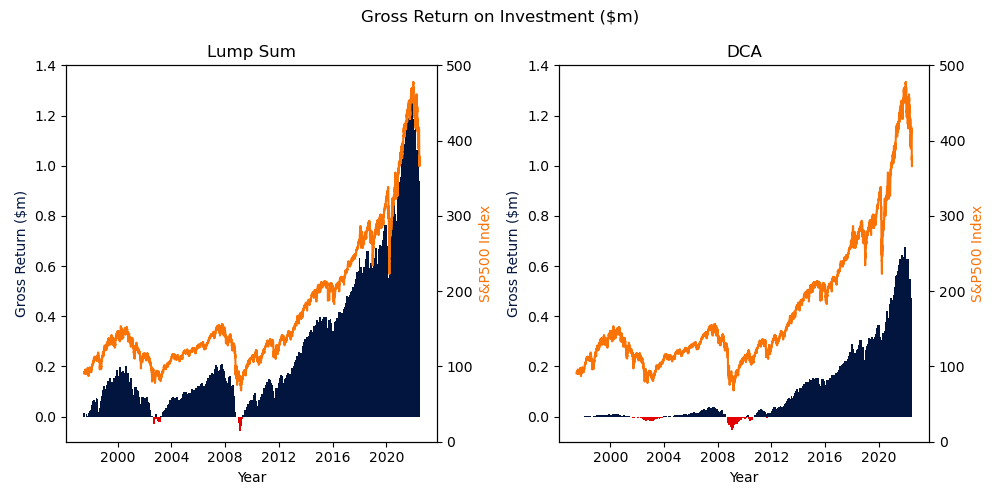

In [ ]:
fig = plt.figure(figsize=(10,5))

ax1 = fig.add_subplot(121)   #top left
ax3 = fig.add_subplot(122)   #top right

ax1.bar(mth_rets_bah.index, mth_rets_bah.Gross_Ret/1e6, color=np.where(mth_rets_bah.Gross_Ret < 0, 'xkcd:red', 'xkcd:navy'), width=50)
ax3.bar(mth_rets_dca.index, mth_rets_dca.Gross_Ret/1e6, color=np.where(mth_rets_dca.Gross_Ret < 0, 'xkcd:red', 'xkcd:navy'), width=50)
ax2 = ax3.twinx()
ax4 = ax1.twinx()
ax4.plot(stockData.index, stockData.Close, color='xkcd:orange')
ax2.plot(stockData.index, stockData.Close, color='xkcd:orange')

ax2.set_ylim(0, 500)
ax4.set_ylim(0, 500)
ax1.set_ylim(-0.1, 1.4)
ax3.set_ylim(-0.1, 1.4)

ax3.set_title("DCA")
ax1.set_title("Lump Sum")
ax1.set_xlabel("Year")
ax3.set_xlabel("Year")
ax1.set_ylabel("Gross Return ($m)", color='xkcd:navy')
ax3.set_ylabel("Gross Return ($m)", color='xkcd:navy')
ax2.set_ylabel('S&P500 Index', color='xkcd:orange')
ax4.set_ylabel('S&P500 Index', color='xkcd:orange')

plt.suptitle('Gross Return on Investment ($m)')
fig.tight_layout()
plt.show()

## Historical Analysis on S&P500 Index

#### Assumptions - that are wrong
1. We can buy for closing price on each day (which is obviously nonsensical, but we'll do it)
2. no fees associated with synthetic ETF
3. no dividends distributed to synthetic ETF
    - conservative assumption that div - fees net out.
4. synthetic ETF holds 1/10 value of S&P500 index
   - no losses associated with end of day portfolio balancing
5. not adjusting values for inflation (nominal value)


https://query1.finance.yahoo.com/v7/finance/download/%5EGSPC?period1=-1325548800&period2=1655769600&interval=1d&filter=history&frequency=1d&includeAdjustedClose=true

In [ ]:
indexData = pd.read_csv('^GSPC.csv')
indexData["Date"] = pd.to_datetime(indexData["Date"], format='%d/%m/%Y')
indexData.set_index('Date', inplace=True)
indexData = indexData.sort_index(ascending=True)
data = bt.feeds.PandasData(dataname=indexData)

abs_min_date = min(indexData.index)
abs_max_date = max(indexData.index)
print('Start Date: {0} \nEnd Date: {1}'.format(abs_min_date, abs_max_date))
SPY = indexData/10
indexData

Start Date: 1928-01-03 00:00:00 
End Date: 2022-06-17 00:00:00


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
1928-01-03,17.760000,17.760000,17.760000,17.760000,17.760000,0
1928-01-04,17.719999,17.719999,17.719999,17.719999,17.719999,0
1928-01-05,17.549999,17.549999,17.549999,17.549999,17.549999,0
1928-01-06,17.660000,17.660000,17.660000,17.660000,17.660000,0
1928-01-09,17.500000,17.500000,17.500000,17.500000,17.500000,0
...,...,...,...,...,...,...
2022-06-13,3838.149902,3838.149902,3734.300049,3749.629883,3749.629883,4572820000
2022-06-14,3763.520020,3778.179932,3705.679932,3735.479980,3735.479980,4126400000
2022-06-15,3764.050049,3837.560059,3722.300049,3789.989990,3789.989990,4474610000


In [ ]:
date_list = indexData.index.tolist()
mth_rets = pd.DataFrame(data=date_list, index=date_list).resample('MS')[0].agg([min, max])
mth_rets.index

dates = pd.date_range(start=abs_min_date, end=abs_max_date, freq='MS')

date_pairs = {}
for ind,date in enumerate(dates):
    sdate = date
    edate = date + datetime.timedelta(weeks=25*52+4)
    if edate < abs_max_date:
        date_pairs[ind] = (sdate, edate)
    else:
        break


print('Start Date: {0} \nEnd Start Date: {1}'.format(abs_min_date, sdate))
print('Number of hypothetical investors:', len(date_pairs), len(date_pairs)/12)

Start Date: 1928-01-03 00:00:00 
End Start Date: 1997-07-01 00:00:00
Number of hypothetical investors: 833 69.41666666666667


## Complete Calculations

833 permutations over Monthly Starting Dates to end of 25 yr holding period

In [ ]:
global dca
dca = {key:[] for key in ["Trades","Value","Cost","Gross_Return","Gross_Per","Fund_Value", "Annualised"]}

global bah
bah = {key:[] for key in ["ROI","Annualised","Gross_Return"]}

This will take a while to run

In [ ]:
for key,(sdate,edate) in date_pairs.items():
    # print(sdate)
    mask = (SPY.index >= sdate) & (SPY.index < edate)
    data = bt.feeds.PandasData(dataname=SPY.loc[mask])
    run(data, results=False, plot=False)

In [ ]:
# bah
len(bah['ROI']),len(bah['Annualised']),len(bah['Gross_Return'])

(833, 833, 833)

export to csv

In [ ]:
df_dca = pd.DataFrame(dca)
df_bah = pd.DataFrame(bah)

df_dca.to_csv('dca.csv', encoding='utf-8', index=False)
df_bah.to_csv('bah.csv', encoding='utf-8', index=False)

NameError: name 'dca' is not defined

import from csv

In [ ]:
df_dca = pd.read_csv('dca.csv')
df_bah= pd.read_csv('bah.csv')

## Compare Gross Return ($m)

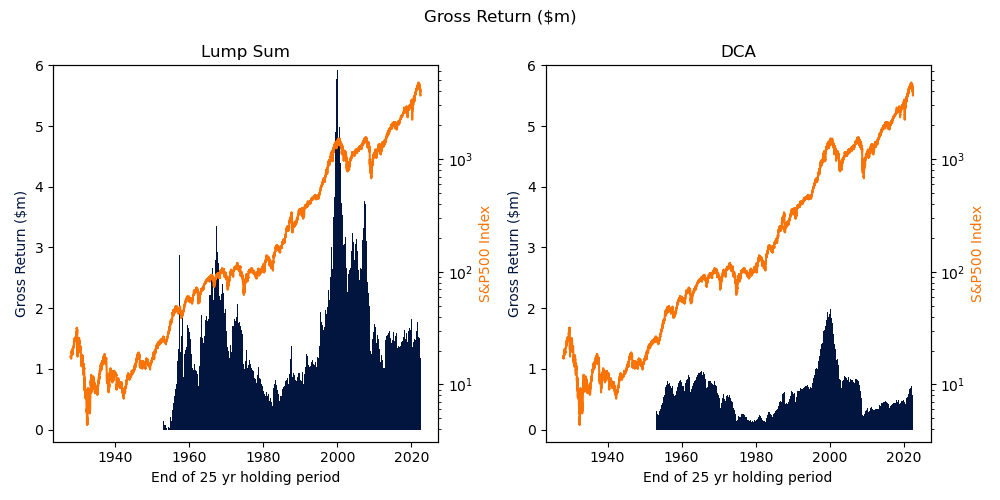

In [ ]:
start_dates = [sdate for val,(sdate,edate) in date_pairs.items()]
end_dates = [edate for val,(sdate,edate) in date_pairs.items()]
fig = plt.figure(figsize=(10,5))
ax1 = fig.add_subplot(121)   #top left
ax3 = fig.add_subplot(122)   #top right


# ax1.bar(start_dates, df_bah.Gross_Return/1e6, width=50)
# ax3.bar(start_dates, df_dca.Gross_Return/1e6, width=50)
ax1.bar(end_dates, df_bah.Gross_Return/1e6, color=np.where(df_bah.Gross_Return < 0, 'xkcd:red', 'xkcd:navy'), width=50)
ax3.bar(end_dates, df_dca.Gross_Return/1e6, color=np.where(df_dca.Gross_Return < 0, 'xkcd:red', 'xkcd:navy'), width=50)
ax2 = ax3.twinx()
ax4 = ax1.twinx()
ax4.plot(indexData.index, indexData.Close, color='xkcd:orange')
ax2.plot(indexData.index, indexData.Close, color='xkcd:orange')

ax1.set_ylim(-0.2, 6)
ax3.set_ylim(-0.2, 6)

ax3.set_title("DCA")
ax1.set_title("Lump Sum")
ax1.set_xlabel("End of 25 yr holding period")
ax3.set_xlabel("End of 25 yr holding period")
ax1.set_ylabel("Gross Return ($m)", color='xkcd:navy')
ax3.set_ylabel("Gross Return ($m)", color='xkcd:navy')
ax2.set_ylabel('S&P500 Index', color='xkcd:orange')
ax4.set_ylabel('S&P500 Index', color='xkcd:orange')
ax2.set_yscale('log')
ax4.set_yscale('log')
plt.suptitle('Gross Return ($m)')
fig.tight_layout()

plt.show()

## Negative Gross Returns ($m)?

In [ ]:
df_bah['start'] = start_dates
df_bah['end'] = end_dates
df_bah = df_bah.set_index(['start','end'])
df_bah[df_bah.Gross_Return < 0]

,,ROI,Annualised,Gross_Return
start,end,,,
1929-01-01,1953-12-29,-0.403047,-0.016148,-1209.140
1929-09-01,1954-08-29,-3.645377,-0.148380,-10936.132


## Compare Gross Return ($m) Histograms

Buy and Hold: percentiles [0.47, 1.41, 3.21]
DCA         : percentiles [0.16, 0.56, 1.4]
Buy and Hold: average     1.56
DCA         : average     0.61
Buy and Hold: CVaR_5      0.18
DCA         : CVaR_5      0.13
-0.010936131999999984 5.9393774175736
0.09611087842559997 1.9894074072465


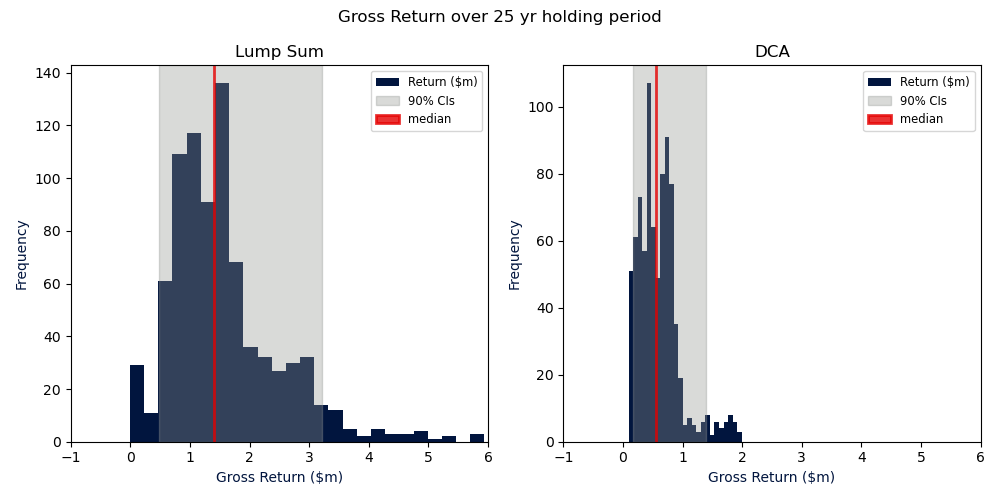

In [ ]:
fig = plt.figure(figsize=(10,5))
ax1 = fig.add_subplot(121)   #top left
ax3 = fig.add_subplot(122)   #top right


# ax1.bar(start_dates, df_bah.Gross_Return/1e6, width=50)
# ax3.bar(start_dates, df_dca.Gross_Return/1e6, width=50)
ax1.hist(df_bah.Gross_Return/1e6, bins=25, color='xkcd:navy', label='Return ($m)')
ax3.hist(df_dca.Gross_Return/1e6, bins=25, color='xkcd:navy', label='Return ($m)')

p5_bah = np.percentile(df_bah.Gross_Return/1e6,5)
p50_bah = np.percentile(df_bah.Gross_Return/1e6,50)
p95_bah = np.percentile(df_bah.Gross_Return/1e6,95)
avg_bah = np.mean(df_bah.Gross_Return/1e6)
CVaR_5_bah = np.mean(df_bah.Gross_Return[df_bah.Gross_Return/1e6 <= p5_bah]/1e6)

p5_dca = np.percentile(df_dca.Gross_Return/1e6,5)
p50_dca = np.percentile(df_dca.Gross_Return/1e6,50)
p95_dca = np.percentile(df_dca.Gross_Return/1e6,95)
avg_dca = np.mean(df_dca.Gross_Return/1e6)
CVaR_5_dca = np.mean(df_dca.Gross_Return[df_dca.Gross_Return/1e6 <= p5_dca]/1e6)
# print(p5_dca, p50_dca, p95_dca)
ax1.set_xlim(-1, 6)
ax3.set_xlim(-1, 6)

#fill in area between the two lines
ax1.axvspan(p5_bah, p95_bah, color='xkcd:grey', alpha=.35, label='90% CIs')
ax3.axvspan(p5_dca, p95_dca, color='xkcd:grey', alpha=.35, label='90% CIs')

ax1.axvspan(p50_bah, p50_bah, color='xkcd:red', alpha=0.8, linewidth=2, label='median')
ax3.axvspan(p50_dca, p50_dca, color='xkcd:red', alpha=0.8, linewidth=2, label='median' )

ax3.set_title("DCA")
ax1.set_title("Lump Sum")
ax1.set_xlabel("Gross Return ($m)", color='xkcd:navy')
ax3.set_xlabel("Gross Return ($m)", color='xkcd:navy')
ax1.set_ylabel("Frequency", color='xkcd:navy')
ax3.set_ylabel("Frequency", color='xkcd:navy')
ax1.legend(loc=1, fontsize='small', fancybox=True)
ax3.legend(loc=1, fontsize='small', fancybox=True)

plt.suptitle('Gross Return over 25 yr holding period')
fig.tight_layout()

print('Buy and Hold: percentiles', [round(val,2) for val in [p5_bah, p50_bah, p95_bah]])
print('DCA         : percentiles', [round(val,2) for val in [p5_dca, p50_dca, p95_dca]])
print('Buy and Hold: average    ', round(avg_bah,2))
print('DCA         : average    ', round(avg_dca,2))
print('Buy and Hold: CVaR_5     ', round(CVaR_5_bah,2))
print('DCA         : CVaR_5     ', round(CVaR_5_dca,2))
print(min(df_bah.Gross_Return/1e6),max(df_bah.Gross_Return/1e6))
print(min(df_dca.Gross_Return/1e6),max(df_dca.Gross_Return/1e6))
plt.show()

## Compare ROI (%) Histograms

Buy and Hold: percentiles [157.34, 469.1, 1068.71]
DCA         : percentiles [53.29, 185.23, 466.62]
Buy and Hold: average     520.91
DCA         : average     202.41
Buy and Hold: CVaR_5      59.5
DCA         : CVaR_5      44.21


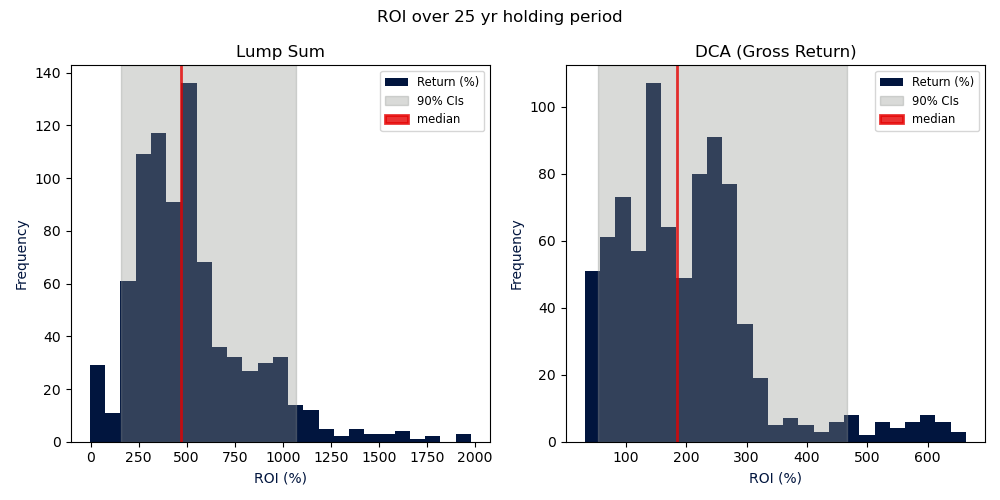

In [ ]:
start_dates = [edate for val,(sdate,edate) in date_pairs.items()]
fig = plt.figure(figsize=(10,5))
ax1 = fig.add_subplot(121)   #top left
ax3 = fig.add_subplot(122)   #top right


# ax1.bar(start_dates, df_bah.Gross_Return/1e6, width=50)
# ax3.bar(start_dates, df_dca.Gross_Return/1e6, width=50)
ax1.hist(df_bah.ROI, bins=25, color='xkcd:navy', label='Return (%)')
ax3.hist(df_dca.Gross_Per, bins=25, color='xkcd:navy', label='Return (%)')

p5_bah = np.percentile(df_bah.ROI,5)
p50_bah = np.percentile(df_bah.ROI,50)
p95_bah = np.percentile(df_bah.ROI,95)
avg_bah = np.mean(df_bah.ROI)
CVaR_5_bah = np.mean(df_bah.ROI[df_bah.ROI <= p5_bah])

p5_dca = np.percentile(df_dca.Gross_Per,5)
p50_dca = np.percentile(df_dca.Gross_Per,50)
p95_dca = np.percentile(df_dca.Gross_Per,95)
avg_dca = np.mean(df_dca.Gross_Per)
CVaR_5_dca = np.mean(df_dca.Gross_Per[df_dca.Gross_Per <= p5_dca])
# print(p5_dca, p50_dca, p95_dca)
# ax1.set_xlim(-1, 16)
# ax3.set_xlim(-1, 16)

#fill in area between the two lines
ax1.axvspan(p5_bah, p95_bah, color='xkcd:grey', alpha=.35, label='90% CIs')
ax3.axvspan(p5_dca, p95_dca, color='xkcd:grey', alpha=.35, label='90% CIs')

ax1.axvspan(p50_bah, p50_bah, color='xkcd:red', alpha=0.8, linewidth=2, label='median')
ax3.axvspan(p50_dca, p50_dca, color='xkcd:red', alpha=0.8, linewidth=2, label='median' )


ax3.set_title("DCA (Gross Return)")
ax1.set_title("Lump Sum")
ax1.set_xlabel("ROI (%)", color='xkcd:navy')
ax3.set_xlabel("ROI (%)", color='xkcd:navy')
ax1.set_ylabel("Frequency", color='xkcd:navy')
ax3.set_ylabel("Frequency", color='xkcd:navy')

plt.suptitle('ROI over 25 yr holding period')
fig.tight_layout()
ax1.legend(loc=1, fontsize='small', fancybox=True)
ax3.legend(loc=1, fontsize='small', fancybox=True)


print('Buy and Hold: percentiles', [round(val,2) for val in [p5_bah, p50_bah, p95_bah]])
print('DCA         : percentiles', [round(val,2) for val in [p5_dca, p50_dca, p95_dca]])
print('Buy and Hold: average    ', round(avg_bah,2))
print('DCA         : average    ', round(avg_dca,2))
print('Buy and Hold: CVaR_5     ', round(CVaR_5_bah,2))
print('DCA         : CVaR_5     ', round(CVaR_5_dca,2))

plt.show()

## Compare Annualized Returns (%) Histograms

Buy and Hold: percentiles [3.85, 7.21, 10.34]
DCA         : percentiles [3.85, 7.2, 10.33]
Buy and Hold: average     7.08
DCA         : average     7.07
Buy and Hold: CVaR_5      1.67
DCA         : CVaR_5      1.67


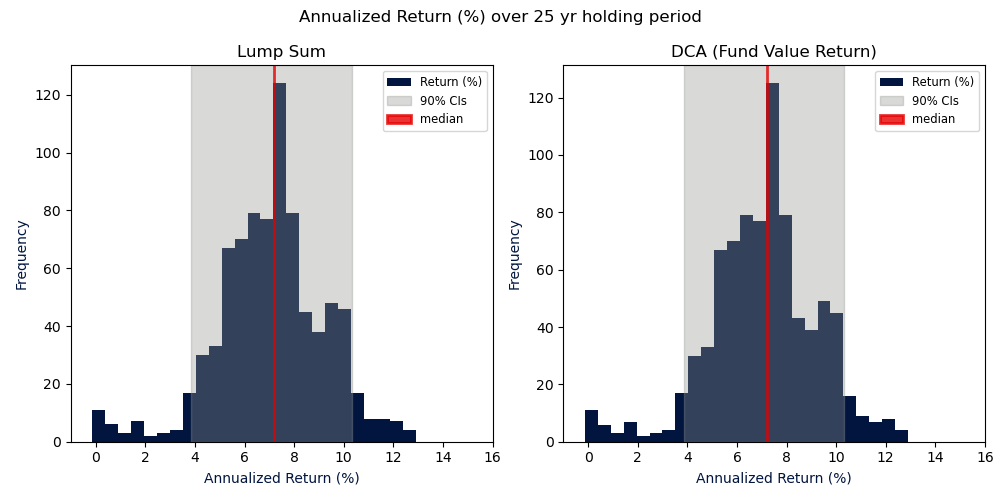

In [ ]:
start_dates = [edate for val,(sdate,edate) in date_pairs.items()]
fig = plt.figure(figsize=(10,5))
ax1 = fig.add_subplot(121)   #top left
ax3 = fig.add_subplot(122)   #top right


# ax1.bar(start_dates, df_bah.Gross_Return/1e6, width=50)
# ax3.bar(start_dates, df_dca.Gross_Return/1e6, width=50)
ax1.hist(df_bah.Annualised, bins=25, color='xkcd:navy', label='Return (%)')
ax3.hist(df_dca.Annualised, bins=25, color='xkcd:navy', label='Return (%)')

p5_bah = np.percentile(df_bah.Annualised,5)
p50_bah = np.percentile(df_bah.Annualised,50)
p95_bah = np.percentile(df_bah.Annualised,95)
avg_bah = np.mean(df_bah.Annualised)
CVaR_5_bah = np.mean(df_bah.Annualised[df_bah.Annualised <= p5_bah])

p5_dca = np.percentile(df_dca.Annualised,5)
p50_dca = np.percentile(df_dca.Annualised,50)
p95_dca = np.percentile(df_dca.Annualised,95)
avg_dca = np.mean(df_dca.Annualised)
CVaR_5_dca = np.mean(df_dca.Annualised[df_dca.Annualised <= p5_dca])
# print(p5_dca, p50_dca, p95_dca)
ax1.set_xlim(-1, 16)
ax3.set_xlim(-1, 16)

#fill in area between the two lines
ax1.axvspan(p5_bah, p95_bah, color='xkcd:grey', alpha=.35, label='90% CIs')
ax3.axvspan(p5_dca, p95_dca, color='xkcd:grey', alpha=.35, label='90% CIs')

ax1.axvspan(p50_bah, p50_bah, color='xkcd:red', alpha=0.8, linewidth=2, label='median')
ax3.axvspan(p50_dca, p50_dca, color='xkcd:red', alpha=0.8, linewidth=2, label='median' )

ax3.set_title("DCA (Fund Value Return)")
ax1.set_title("Lump Sum")
ax1.set_xlabel("Annualized Return (%)", color='xkcd:navy')
ax3.set_xlabel("Annualized Return (%)", color='xkcd:navy')
ax1.set_ylabel("Frequency", color='xkcd:navy')
ax3.set_ylabel("Frequency", color='xkcd:navy')

plt.suptitle('Annualized Return (%) over 25 yr holding period')
fig.tight_layout()

ax1.legend(loc=1, fontsize='small', fancybox=True)
ax3.legend(loc=1, fontsize='small', fancybox=True)

print('Buy and Hold: percentiles', [round(val,2) for val in [p5_bah, p50_bah, p95_bah]])
print('DCA         : percentiles', [round(val,2) for val in [p5_dca, p50_dca, p95_dca]])
print('Buy and Hold: average    ', round(avg_bah,2))
print('DCA         : average    ', round(avg_dca,2))
print('Buy and Hold: CVaR_5     ', round(CVaR_5_bah,2))
print('DCA         : CVaR_5     ', round(CVaR_5_dca,2))

plt.show()